# Evaluation of Profile detector

### Environment

Imports

In [87]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pathlib import Path

import torch

from torch.utils.data import DataLoader, random_split

from test import confusion, evaluate
from dataset import ProfileDataset, get_balanced_sampler
from model import ProfileDetector

Config

In [88]:
TRAIN_DATA_PATH = '../dataset/train'
TEST_DATA_PATH = '../dataset/test'
MODEL_DIR = '../trained_models'
MODEL_NAME = 'profile_detector_freeze_val'

Make plots wider

In [89]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10, 5)

### Model and dataset

In [90]:
model_path = Path(MODEL_DIR) / f'{MODEL_NAME}_final'
model = ProfileDetector(pretrained=True, freeze_backbone=True)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [91]:
dataset = ProfileDataset(TRAIN_DATA_PATH, augment=False)

generator = torch.Generator().manual_seed(42)
_, val_dataset = random_split(dataset, [0.9, 0.1], generator)
sampler = get_balanced_sampler(val_dataset, dataset.targets, 0.9, generator)
val_loader = DataLoader(val_dataset, batch_size=64, sampler=sampler, generator=generator)
print(f"Loaded validation dataset with {len(val_dataset)} images.")

Loaded validation dataset with 165 images.


In [92]:
test_dataset = ProfileDataset(TEST_DATA_PATH, augment=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print(f"Loaded test dataset with {len(test_dataset)} images.")

Loaded test dataset with 343 images.


In [93]:
dist = sum(1 for t in dataset.targets if t) / len(dataset)
print("Data distribution in training data:\t{:.1f}% (good) / {:.1f}% (bad)".format(dist*100, 100-dist*100))
dist = sum(1 for t in test_dataset.targets if t) / len(test_dataset)
print("Data distribution in test data:\t\t{:.1f}% (good) / {:.1f}% (bad)".format(dist*100, 100-dist*100))

Data distribution in training data:	39.1% (good) / 60.9% (bad)
Data distribution in test data:		100.0% (good) / 0.0% (bad)


Select data to plot

In [94]:
data_loader = val_loader

### Load loss and accuracy

In [95]:
metrics_path = Path(MODEL_DIR) / f'{MODEL_NAME}_metrics.csv'
metrics = pd.read_csv(metrics_path)

### Plot loss

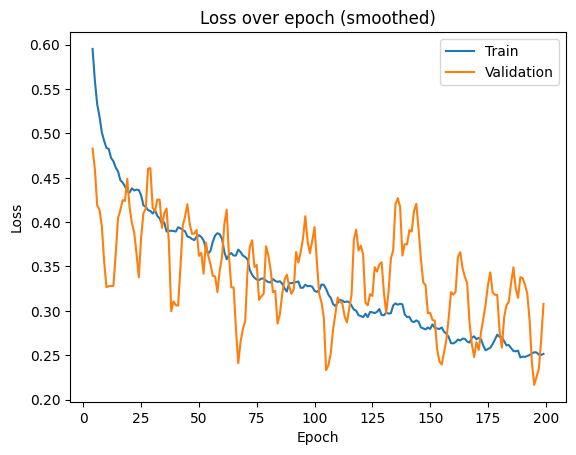

In [96]:
window_size = 5

s_metrics = metrics[['train loss', 'validation loss']].copy()
s_metrics['train loss'] = metrics['train loss'].rolling(window_size).mean()
s_metrics['validation loss'] = metrics['validation loss'].rolling(window_size).mean()

s_metrics.plot(y=['train loss', 'validation loss'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch (smoothed)')
plt.legend(['Train', 'Validation'])

plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_loss_smooth.pdf')

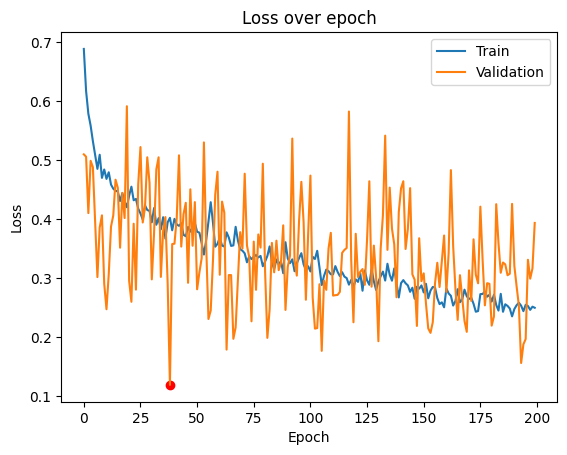

In [97]:
metrics.plot(y=['train loss', 'validation loss'], kind='line')

best_epoch = metrics['validation loss'].idxmin()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation loss'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_loss.pdf')

### Plot accuracy

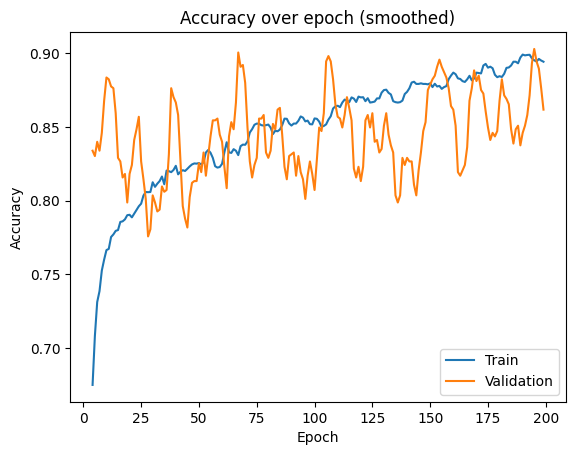

In [98]:
window_size = 5

s_metrics = metrics[['train accuracy', 'validation accuracy']].copy()
s_metrics['train accuracy'] = metrics['train accuracy'].rolling(
    window_size).mean()
s_metrics['validation accuracy'] = metrics['validation accuracy'].rolling(
    window_size).mean()

s_metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch (smoothed)')
plt.legend(['Train', 'Validation'])
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_acc_smooth.pdf')

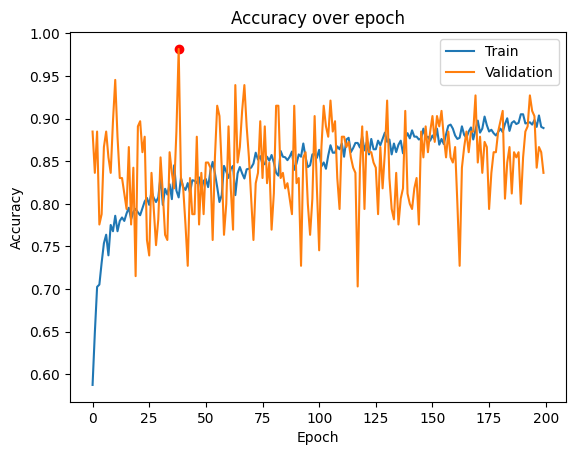

In [99]:
metrics.plot(y=['train accuracy', 'validation accuracy'], kind='line')

best_epoch = metrics['validation accuracy'].idxmax()
plt.scatter(x=best_epoch, y=metrics.loc[best_epoch,
            'validation accuracy'], color='red', label='Best epoch')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epoch')
plt.legend(['Train', 'Validation'])
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_acc.pdf')

### Create predictions

In [100]:
outs = torch.empty((0, 1))
targets = torch.empty((0, 1))
with torch.no_grad():
    for input, target in data_loader:
        input.requires_grad_(False)
        model.eval()
        out = model(input)
        outs = torch.cat([outs, out])
        targets = torch.cat([targets, target])

print(outs.shape)

torch.Size([165, 1])


### Confusion matrix

In [101]:
print("Confusion matrix at t=0.1")
cm = confusion(outs, targets, thresh=0.1)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.25")
cm = confusion(outs, targets, thresh=0.25)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.5")
cm = confusion(outs, targets, thresh=0.5)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.75")
cm = confusion(outs, targets, thresh=0.75)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

print("Confusion matrix at t=0.9")
cm = confusion(outs, targets, thresh=0.9)
p, r, f1, acc = evaluate(cm)
print("P: {:.3f}, R: {:.3f}, F1: {:.3f}, Acc: {:.3f}".format(p, r, f1, acc))
print(cm)

Confusion matrix at t=0.1
P: 0.235, R: 1.000, F1: 0.381, Acc: 0.685
[[97 52]
 [ 0 16]]
Confusion matrix at t=0.25
P: 0.348, R: 1.000, F1: 0.516, Acc: 0.818
[[119  30]
 [  0  16]]
Confusion matrix at t=0.5
P: 0.484, R: 0.938, F1: 0.638, Acc: 0.897
[[133  16]
 [  1  15]]
Confusion matrix at t=0.75
P: 0.579, R: 0.688, F1: 0.629, Acc: 0.921
[[141   8]
 [  5  11]]
Confusion matrix at t=0.9
P: 0.769, R: 0.625, F1: 0.690, Acc: 0.945
[[146   3]
 [  6  10]]


### Performance at difference thresholds

c:\Users\victo\Documents\Linköpings Universitet\5\TSBB11\emotioncapture\profile_detector\test.py:27: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])


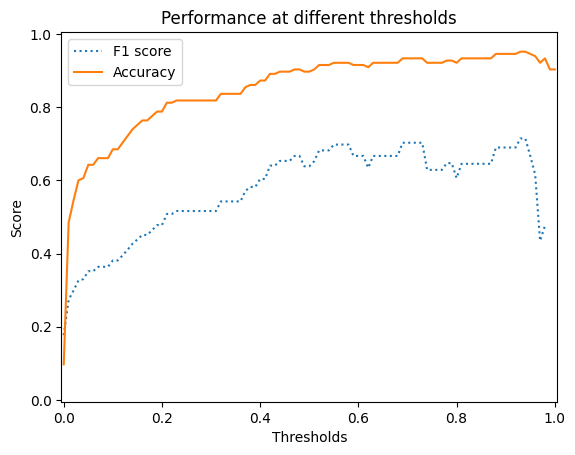

In [102]:
thresholds = np.arange(0.0, 1.01, 0.01)

f1s, accs = [], []
for thresh in thresholds:
    cm = confusion(outs, targets, thresh=thresh)
    p, r, f1, acc = evaluate(cm)
    f1s, accs = [*f1s, f1], [*accs, acc]

plt.plot(thresholds, f1s, label="F1 score", linestyle=':')
plt.plot(thresholds, accs, label="Accuracy", linestyle='-')
plt.legend()
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title('Performance at different thresholds')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_performance.pdf')

### Precision-recall curve

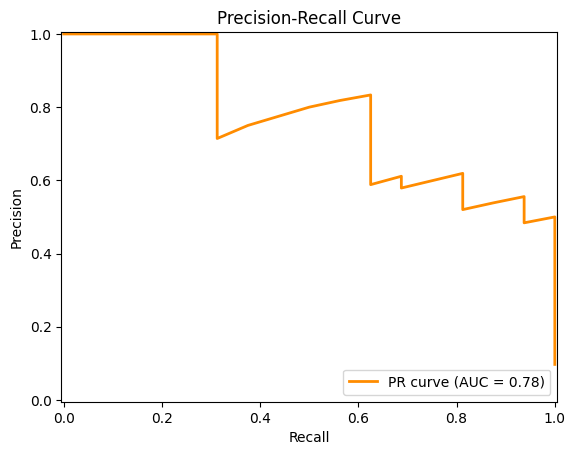

In [103]:
from sklearn.metrics import precision_recall_curve, average_precision_score

__precision, __recall, _ = precision_recall_curve(targets, outs)
pr_auc = average_precision_score(targets, outs)
plt.plot(__recall, __precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.legend(loc='lower right')
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_perrec.pdf')

### ROC curve

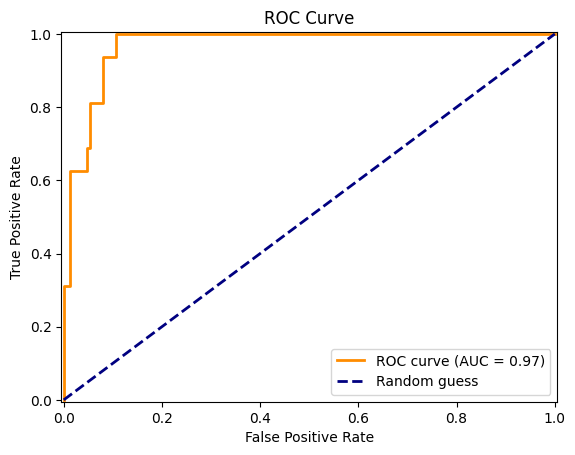

In [104]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(targets, outs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.xlim(-0.005, 1.005)
plt.ylim(-0.005, 1.005)
plt.savefig(MODEL_DIR + f'/{MODEL_NAME}_roc.pdf')